In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('\n')
print(device_lib.list_local_devices())

Num GPUs Available:  1


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8110148550995402946
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40282292224
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14946728177795215342
physical_device_desc: "device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0"
xla_global_id: 416903419
]


2021-12-02 13:49:13.574533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 13:49:13.580401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 13:49:13.581425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 13:49:13.582934: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 1000)              785000    
                                                                 
 dense_95 (Dense)            (None, 10)                10010     
                                                                 
Total params: 795,010
Trainable params: 795,010
Non-trainable params: 0
_________________________________________________________________
BATCH SIZE: 1024
Training...
Testing in-sample...
Testing out-of-sample...
Training the model took 1.707469638902694 seconds
Sample time processing: 65818.95782412933 sample/seconds
Training duration summing batch processing time: 0.9023540019989014 seconds
Sample time processing during inference in-sample: 51854.18012681411 sample/seconds
Testing the model in-sample took 1.1570909009315073
Sample time processing during inference out-of-sa

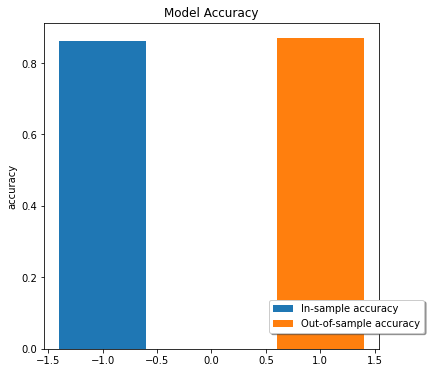

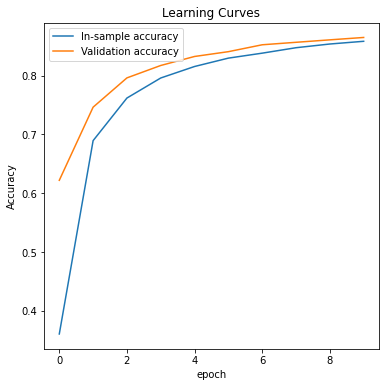

In [39]:
# FULLY CONNECTED NEURAL NETWORK

import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time
from timeit import default_timer as timer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.utils.np_utils import to_categorical
from functools import reduce
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

hidden_layer_list = [1000] # This list is read from the settings file
input_size = 28*28
output_size = 10
n_epochs = 10
batch_size = 1024

dev = '/device:GPU:0'
# dev = '/cpu:0'

# Timing callback definition
class TimeHistory(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
      self.batch_times = []
      self.epoch_times = []
      self.training_time = []
      self.training_time_start = time.time()
  def on_batch_begin(self, batch, logs={}):
      self.batch_time_start = time.time()
  def on_batch_end(self, batch, logs={}):
      self.batch_times.append(time.time() - self.batch_time_start)
  def on_epoch_begin(self, batch, logs={}):
      self.epoch_time_start = time.time()
  def on_epoch_end(self, batch, logs={}):
      self.epoch_times.append(time.time() - self.epoch_time_start)
  def on_train_end(self, batch, logs={}):
      self.training_time.append(time.time() - self.training_time_start)

# Data loading method
def data_loading(output):
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  # Data preprocessing: I have to rescale and flatten all the images
  shape = (28, 28)
  shape_l = reduce(lambda a, b: a*b, shape)
  x_train = x_train.reshape((-1, shape_l)) / 255.
  x_test  = x_test.reshape((-1, shape_l)) / 255.
  # One-hot encoding
  y_train = to_categorical(y_train, num_classes = output)
  y_test  = to_categorical(y_test, num_classes = output)
  return (x_train, y_train), (x_test, y_test)

# Model defintion method
def model_def(hidden_layer, input, output): # hidden_layer is a list containing the number of neurons for each hidden layer
  model = Sequential()
  for i in range(len(hidden_layer)+1):
    if i == 0:
      model.add(Dense(hidden_layer[i], activation='relu', input_shape=(input_size,)))
    elif i == len(hidden_layer):
      model.add(Dense(output_size, activation='softmax'))
    else:
      model.add(Dense(hidden_layer[i], activation='relu'))
  loss = keras.losses.CategoricalCrossentropy()
  optim = keras.optimizers.SGD(learning_rate=0.01, momentum=0.05)
  metrics=["accuracy"]
  model.compile(loss=loss, optimizer=optim, metrics=metrics)
  return model  

def main():
  (X_train, Y_train), (X_test, Y_test) = data_loading(output_size)
  nn = model_def(hidden_layer_list, input_size, output_size)
  nn.summary()

  print("BATCH SIZE: %s" % batch_size)

  ##############
  ## TRAINING ##
  ##############

  time_callback = TimeHistory()
  print("Training...")
  nn = model_def(hidden_layer_list, input_size, output_size)
  begin = timer() # Duration of the whole fit() method run
  history = nn.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, callbacks=[time_callback], validation_split=0.3, verbose=0)
  training_time = timer() - begin # Duration of the whole fit() method run
  training_time_sum_over_batches = sum(time_callback.batch_times)
  time_per_sample = training_time_sum_over_batches/((len(X_train)//batch_size)*batch_size)
  sample_per_second = 1./time_per_sample
  
  #######################
  ## TESTING IN-SAMPLE ##
  #######################

  print("Testing in-sample...")
  # Evaluate the model in-sample
  begin = timer() # Inference time on training set
  pred = nn.predict(X_train).argmax(1)
  testing_time_insample = timer() - begin # Inference time on training set
  test_accuracy_in_sample = accuracy_score(Y_train.argmax(1), pred, normalize=False)/len(X_train)
  time_per_sample_test_insample = testing_time_insample/len(X_train)
  sample_per_second_test_insample = 1./time_per_sample_test_insample

  ###########################
  ## TESTING OUT-OF-SAMPLE ##
  ###########################

  print("Testing out-of-sample...")
  # Evaluate the model out-of-sample
  begin = timer() # Inference time on training set
  pred = nn.predict(X_test).argmax(1)
  testing_time_outofsample = timer() - begin # Inference time on training set
  test_accuracy_out_of_sample = accuracy_score(Y_test.argmax(1), pred, normalize=False)/len(X_test)
  time_per_sample_test_outofsample = testing_time_outofsample/len(X_test)
  sample_per_second_test_outofsample = 1./time_per_sample_test_outofsample

  #####################
  ## DISPLAY RESULTS ##
  #####################

  # Accuracy Report
  fig = plt.figure(facecolor='white')
  fig.set_figheight(6)
  fig.set_figwidth(6)
  plt.bar(-1, test_accuracy_in_sample, label='In-sample accuracy')
  plt.bar(1, test_accuracy_out_of_sample, label='Out-of-sample accuracy')
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.legend(loc='right', bbox_to_anchor=(1.15,0.1), fancybox=True, shadow=True, ncol= 1)

  # Learning curves
  fig = plt.figure(facecolor='white')
  fig.set_figheight(6)
  fig.set_figwidth(6)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Learning Curves')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['In-sample accuracy', 'Validation accuracy'], loc='upper left')


  print("Training the model took %s seconds" % training_time)
  print("Sample time processing: %s sample/seconds" % sample_per_second)
  print("Training duration summing batch processing time: %s seconds" % training_time_sum_over_batches)

  print("Sample time processing during inference in-sample: %s sample/seconds" % sample_per_second_test_insample)
  print("Testing the model in-sample took %s" % testing_time_insample)

  print("Sample time processing during inference out-of-sample: %s sample/seconds" % sample_per_second_test_outofsample)
  print("Testing the model took %s" % testing_time_outofsample)

  return 0

if __name__=="__main__":
  with tf.device(dev):
    main()

(28, 28)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense_38 (Dense)            (None, 784)               4240656   
                                                                 
 dense_39 (Dense)            (None, 10)                7850      
                                                                 
Total params: 4,248,826
Trainable params: 4,248,826
Non-trainable params: 0
__________________________________

2021-12-02 14:45:25.797722: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


329/329 [==============================] - 2s 3ms/step - loss: 1.0248 - accuracy: 0.7729 - val_loss: 0.4085 - val_accuracy: 0.8834
Epoch 2/10
329/329 [==============================] - 1s 3ms/step - loss: 0.3611 - accuracy: 0.8992 - val_loss: 0.3254 - val_accuracy: 0.9031
Epoch 3/10
329/329 [==============================] - 1s 3ms/step - loss: 0.2965 - accuracy: 0.9141 - val_loss: 0.3292 - val_accuracy: 0.8971
Epoch 4/10
329/329 [==============================] - 1s 3ms/step - loss: 0.2607 - accuracy: 0.9245 - val_loss: 0.2564 - val_accuracy: 0.9243
Epoch 5/10
329/329 [==============================] - 1s 3ms/step - loss: 0.2338 - accuracy: 0.9320 - val_loss: 0.2514 - val_accuracy: 0.9250
Epoch 6/10
329/329 [==============================] - 1s 3ms/step - loss: 0.2134 - accuracy: 0.9384 - val_loss: 0.2090 - val_accuracy: 0.9391
Epoch 7/10
329/329 [==============================] - 1s 3ms/step - loss: 0.1951 - accuracy: 0.9432 - val_loss: 0.2386 - val_accuracy: 0.9241
Epoch 8/10
329/32

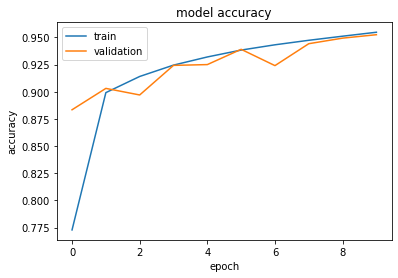

Training the model took 10.616369389928877


In [22]:
# CONVOLUTIONAL NEURAL NETWORK

import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.utils.np_utils import to_categorical
from functools import reduce
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping

hidden_layer_list = [1000] # This list is read from the settings file
output_size = 10
n_epochs = 10
batch_size = 128

dev = '/device:GPU:0'
# dev = '/cpu:0'

def data_loading(output):
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  input_size = x_train.shape[1:]
  print(input_size)
  # Data preprocessing: I have to rescale and flatten all the images
  x_train = x_train / 255.
  x_test  = x_test / 255.
  # One-hot encoding
  y_train = to_categorical(y_train, num_classes = output)
  y_test  = to_categorical(y_test, num_classes = output)
  return (x_train, y_train), (x_test, y_test)


def model_def(hidden_layer, input, output): # hidden_layer is a list containing the number of neurons for each hidden layer
  model = Sequential()
  for i in range(len(hidden_layer)+1):
    if i == 0:
      model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
      model.add(MaxPooling2D((2, 2)))
    elif i == len(hidden_layer):
      model.add(Flatten())
      model.add(Dense(28*28, activation='relu'))
      model.add(Dense(output_size, activation='softmax'))
    else:
      model.add(Conv2D(32, (3, 3), activation='relu'))
      model.add(MaxPooling2D((2, 2)))

  # model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(28,28,1)))
  # model.add(Conv2D(32, (3, 3), activation='relu'))
  # model.add(Flatten())
  # model.add(Dense(28*28, activation='relu'))
  # model.add(Dense(output_size, activation='softmax'))
  

  loss = keras.losses.CategoricalCrossentropy()
  optim = keras.optimizers.SGD(learning_rate=0.01, momentum=0.05)
  metrics=["accuracy"]
  model.compile(loss=loss, optimizer=optim, metrics=metrics)
  model.summary()
  return model  

def main():
  (X_train, Y_train), (X_test, Y_test) = data_loading(output_size)
  nn = model_def(hidden_layer_list, input_size, output_size)

  es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, patience=4)

  # Time the training
  begin = timer()
  # history = nn.fit(X_train, Y_train, batch_size=64, epochs=10, validation_split=0.3, shuffle=True, callbacks=es, verbose=1)
  history = nn.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.3, shuffle=True, verbose=1)
  training_time = timer() - begin

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # Time the testing


  # Report computation time
  print("Training the model took %s" % training_time)

  return 0

if __name__=="__main__":
  with tf.device(dev):
    main()